# Hotel Recognition to Combat Human Trafficking | Exploratory Data Analysis
    2021-04-05
    Edward Sims

## Introduction
Victims of human trafficking are often photographed in hotel rooms as in the below examples. Identifying these hotels is vital to these trafficking investigations but poses particular challenges due to low quality of images and uncommon camera angles.

![Image from Kaggle competition page: https://www.kaggle.com/c/hotel-id-2021-fgvc8/overview/description](images/example_victim_images.png)

Even without victims in the images, hotel identification in general is a challenging fine-grained visual recognition task with a huge number of classes and potentially high intraclass and low interclass variation. In order to support research into this challenging task and create image search tools for human trafficking investigators, we created the TraffickCam mobile application, which allows every day travelers to submit photos of their hotel room. Read more about [TraffickCam on TechCrunch](https://techcrunch.com/2016/06/25/traffickcam/).

## Evaluation
Submissions are evaluated according to the Mean Average Precision @ 5 (MAP@5):

<img src="images/map5_formula.png" alt="MAP@5 formula" style="width: 300px;"/>

where ***U*** is the number of images, ***P(k)*** is the precision at cutoff ***k***, ***n*** is the number of predictions per image, and ***rel(k)*** is an indicator function equaling 1 if the item at rank ***k*** is a relevant correct label, zero otherwise.

Once a correct label has been scored for an observation, that label is no longer considered relevant for that observation, and additional predictions of that label are skipped in the calculation. For example, if the correct label is ***A*** for an observation, the following predictions all score an average precision of 1.0.

```
A B C D E
A A A A A
A B A C A
```

## Submission File
For each image in the test set, you must predict a space-delimited list of hotel IDs that could match that image. The list should be sorted such that the first ID is considered the most relevant one and the last the least relevant one. The file should contain a header and have the following format:

```
image,hotel_id 
99e91ad5f2870678.jpg,36363 53586 18807 64314 60181
b5cc62ab665591a9.jpg,36363 53586 18807 64314 60181
d5664a972d5a644b.jpg,36363 53586 18807 64314 60181
```

## Data 
Identifying the location of a hotel room is a challenging problem of great interest for combating human trafficking. This competition provides a rich dataset of photos of hotel room interiors, without any people present, for this purpose.

Many of the hotels are independent or part of very small chains, where shared decor isn't a concern. However, the shared standards for their interior decoration for the larger chains means that many hotels can look quite similar at first glance. Identifying the chain can narrow the range of possibilities, but only down to a set that is much harder to tell apart and is still scattered across a wide geographic area. The real value lies in getting the number of candidates to a small enough number that a human investigator could follow up on all of them.

### Files
**train.csv** - The training set metadata.
 - `image` - The image ID.
 - `chain` - An ID code for the hotel chain. A chain of zero (0) indicates that the hotel is either not part of a chain or the chain is not known. This field is not available for the test set. The number of hotels per chain varies widely.
 - `hotel_id` - The hotel ID. The target class.
 - `timestamp` - When the image was taken. Provided for the training set only.
 
**sample_submission.csv** - A sample submission file in the correct format.
 - `image` The image ID
 - `hotel_id` The hotel ID. The target class.
 
**train_images** - The training set contains 97000+ images from around 7700 hotels from across the globe. All of the images for each hotel chain are in a dedicated subfolder for that chain.

**test_images** - The test set images. This competition has a hidden test set: only three images are provided here as samples while the remaining 13,000 images will be available to your notebook once it is submitted.

## 1.00 Import Packages

In [1]:
# Data manipulation packages
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime as dt
import cv2

# General packages
import multiprocessing
import pickle
import os
import gc
import random
from tqdm import tqdm, tqdm_notebook
import time
import warnings

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Package options
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = [14, 8]
np.random.seed(14)

## 2.00 Read in data

In [2]:
# Data paths
data_dir_path         = "../input/hotel-id-2021-fgvc8"
train_images_dir_path = os.path.join(data_dir_path, "train_images")
test_images_dir_path  = os.path.join(data_dir_path, "test_images")

train_metadata_path   = os.path.join(data_dir_path, "train.csv")
sample_sub_path       = os.path.join(data_dir_path, "sample_submission.csv")

# Read csv data
train_metadata        = pd.read_csv(train_metadata_path, parse_dates=["timestamp"])
sample_sub            = pd.read_csv(sample_sub_path)

In [3]:
# Set image parameters
ROWS     = 128 # Default row size
COLS     = 128 # Default col size
CHANNELS = 3

# Get number of cpu cores for multiprocessing
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 1 # Default number of cores

## 3.00 Metadata Analysis


### 3.01 Initial Checks

In [4]:
train_metadata.head()

,image,chain,hotel_id,timestamp
0,8000d59f6a3d765f.jpg,85,24607,2018-11-28 05:42:31
1,8000febe81817f7f.jpg,6,25389,2017-01-01 07:01:46
2,80053befc2d42fba.jpg,3,672,2018-01-26 13:22:07
3,8007fa0a8fe89f9d.jpg,5,63866,2020-07-03 02:31:31
4,800a4a6b6f6d2df6.jpg,0,12036,2017-09-22 17:59:22


In [5]:
train_metadata.tail()

,image,chain,hotel_id,timestamp
97551,ffff8082ec219892.jpg,83,20544,2016-12-18 03:04:54
97552,ffff8200e50cc0f1.jpg,82,51053,2018-01-23 03:51:42
97553,ffff84129981a4a4.jpg,83,42842,2017-03-30 22:45:24
97554,ffff85015040c2af.jpg,82,6261,2016-11-09 12:34:06
97555,ffffc0c05f2820c1.jpg,79,58764,2017-06-14 21:55:37


In [6]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97556 entries, 0 to 97555
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   image      97556 non-null  object        
 1   chain      97556 non-null  int64         
 2   hotel_id   97556 non-null  int64         
 3   timestamp  97556 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.0+ MB


### 3.02 Duplicates

In [7]:
# Print high level stats on metadata dimensions
print(f"Train metadata dimensions: \t{train_metadata.shape}")
print(f"Number of unique records: \t{len(train_metadata.drop_duplicates())}")
print(f"Number of unique image names: \t{train_metadata['image'].nunique()}")

Train metadata dimensions: 	(97556, 4)
Number of unique records: 	97556
Number of unique image names: 	97554


There appear to be two duplicated image names, but these aren't considered duplicate records. We'll investigate these two records individually.

In [8]:
# Subset duplicated image names - to all records (not just duplicates)
train_metadata.loc[train_metadata.groupby("image")["image"].transform("count") > 1, ]

,image,chain,hotel_id,timestamp
56845,c7c7383898d76598.jpg,6,60918,2020-07-18 00:03:38
56846,c7c7383898d76598.jpg,6,60918,2020-08-29 04:35:13
62238,ce27d36c9147cc19.jpg,6,60918,2020-07-18 00:03:38
62239,ce27d36c9147cc19.jpg,6,60918,2020-08-29 04:35:13


It looks like these records have indeed been duplicated, and the names have just been switched around. We can remove 1 of each record. 

Although 2 records don't seem like a lot in the grand scheme of things (i.e. out of 97,554 total records), but every marginal improvement in the data quality is **critical** to model improvement. 

In [9]:
# Remove 2 duplicated records
train_metadata_dupes = train_metadata.loc[train_metadata.groupby("image")["image"].transform("count") > 1, ]
train_metadata_dupes_idx = train_metadata_dupes.iloc[[1, 3]].index
train_metadata = train_metadata.drop(train_metadata_dupes_idx, axis=0)

In [10]:
# Observe any duplicates using chain, hotel_id and timestamp columns
train_metadata[train_metadata.duplicated(
    subset=["chain", "hotel_id", "timestamp"], keep=False
)].sort_values(["chain", "hotel_id", "timestamp"])

,image,chain,hotel_id,timestamp
4193,8597c66e7391994c.jpg,0,204,2016-11-11 20:47:06
6184,87b5cbc0cc9cd8cc.jpg,0,204,2016-11-11 20:47:06
15175,93964ced92cc29b6.jpg,0,204,2016-11-11 20:47:06
71157,d89c8f0f70b0686f.jpg,0,204,2016-11-11 20:47:06
37149,adec21fa1b609a65.jpg,0,204,2017-10-08 20:59:29
...,...,...,...,...
92514,f8fc07c39748c1b4.jpg,91,47164,2016-06-28 17:08:15
65887,d2472a50cf35cd3a.jpg,91,47164,2019-09-23 19:16:34
70709,d7d478cfcb046381.jpg,91,47164,2019-09-23 19:16:34
72056,d9b39a56e25ca861.jpg,91,47164,2019-09-23 19:16:34


Excluding the image column, most images are considered duplicates - this won't actually be the case however. Rather, it can possibly be that the timestamp column is not wholly accurate. Images may have been batch uploaded, or the timestamp column doesn't precisely measure the actual time these images were taken. 

The timestamp feature will be analysed in more detail to see if there is any value in including this feature as part of our model training. While it is not included as a feature in the test set, if informative, we can use it in our cross validation strategy. 

And as for possible image duplicates (where the metadata appear unique, but the actual image isn't), this will also be analysed in subsequent sections.

### 3.03 Chain ID Analysis

In [11]:
print(f"Number of unique chain ids: {train_metadata['chain'].nunique()}")

Number of unique chain ids: 88


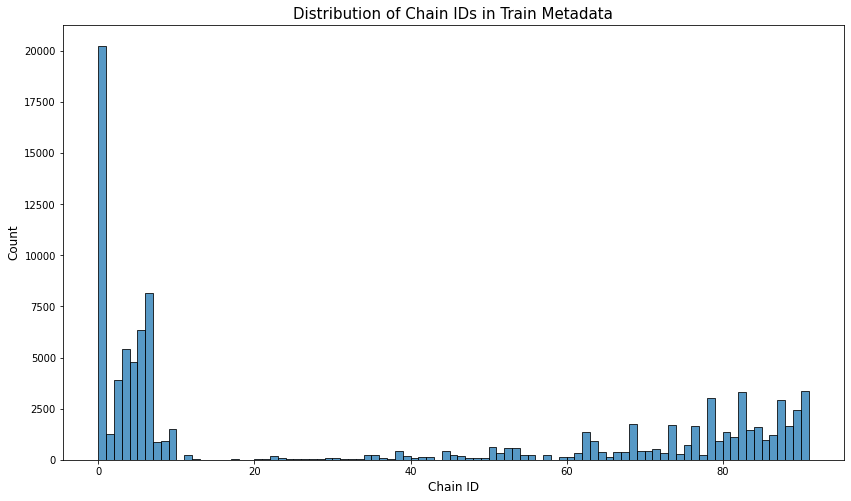

In [12]:
# Plot histogram of chain ids
sns.histplot(data=train_metadata, x="chain", stat="count", binwidth=1)
plt.xlabel("Chain ID", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Chain IDs in Train Metadata", fontsize=15)
plt.show()

We'll definitely have to stratify by chain during cross validation - there's a heavy 'skew' (there's no particular distribution) towards lower chain ID integers, as well as some increase in counts towards the higher end of chain ID integers also. The middle range appears quite sparse, so we should take extra care not to allow our model to favour only chain IDs in the majority groups.

In [13]:
# Display descriptive stats on numbers of records per chain id
train_chain_stats = pd.DataFrame(train_metadata["chain"].value_counts())
train_chain_stats.describe().rename(columns={"chain": "Chain ID Count Statistics"})

,Chain ID Count Statistics
count,88.000000
mean,1108.568182
std,2528.773719
min,8.000000
25%,80.750000
50%,262.500000
75%,1144.500000
max,20259.000000


Confirming the histogram above, there's a pretty huge standard deviation for number of records per chain id. We'll need to do some significant work and likely have to iterate on this topic to find an optimal solution.

Given that the minimum number of records for a chain is 8, it might be useful to look into sampling strategies. We could potentially upsample the low frequency chains and downsample (if needed) the chains with high frequency. This will be explored in later sections and in the modelling notebooks.

### 3.04 Hotel ID Analysis

In [14]:
print(f"Number of unique hotel ids: {train_metadata['hotel_id'].nunique()}")

Number of unique hotel ids: 7770


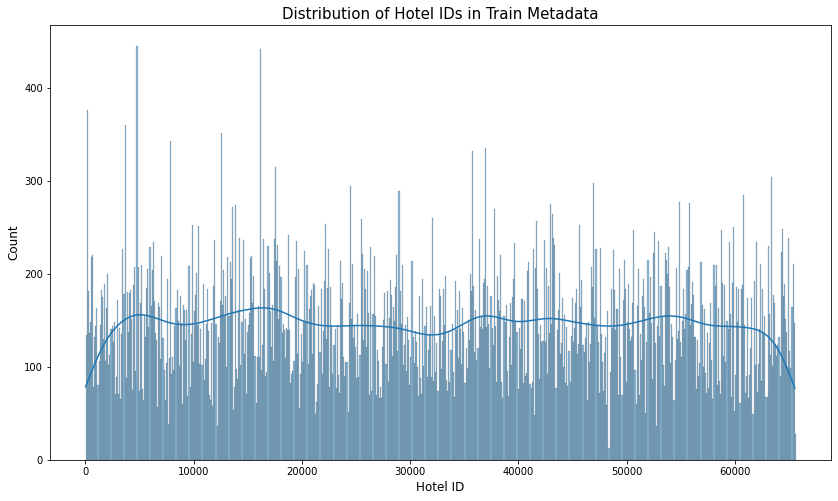

In [15]:
# Plot histogram of chain ids
sns.histplot(data=train_metadata, x="hotel_id", stat="count", binwidth=100, kde=True)
plt.xlabel("Hotel ID", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Hotel IDs in Train Metadata", fontsize=15)
plt.show()

There appear to be a fairly even distribution of hotel IDs, despite the skews in chain ID. This will be beneficial to modelling. What will be tricky for modelling, is the sheer number of classes (7,770 is a huge number of classes for the size of the dataset).

In [16]:
# Display descriptive stats on numbers of records per chain id
train_hotel_id_stats = pd.DataFrame(train_metadata["hotel_id"].value_counts())
train_hotel_id_stats.describe().rename(columns={"hotel_id": "Chain ID Count Statistics"})

,Chain ID Count Statistics
count,7770.000000
mean,12.555212
std,11.802254
min,1.000000
25%,8.000000
50%,8.000000
75%,12.000000
max,95.000000


The fact that the standard deviation is less than the mean is promising, in terms of distribution. But a minimum count of hotel ID records of 1, and a maximum of 95, might mean we'll need to explore sampling strategies similar to with chain ID. Stratifying by 7,770 different classes on the other hand might not be feasible.

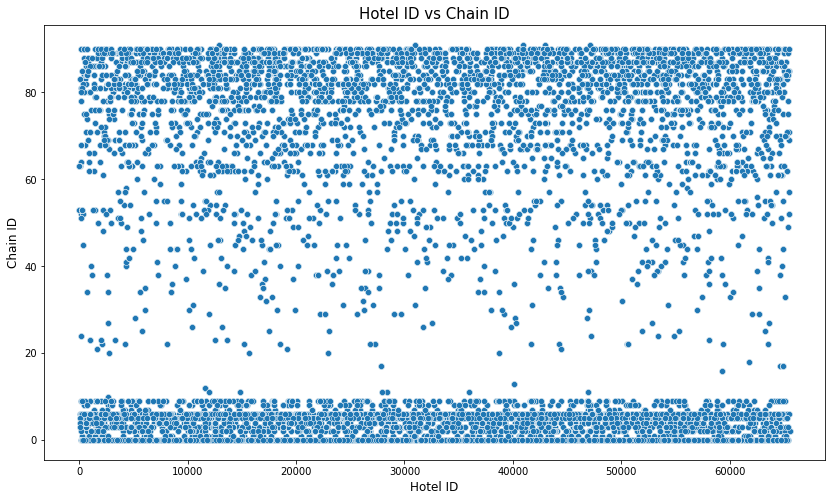

In [17]:
sns.scatterplot(data=train_metadata, x="hotel_id", y="chain")
plt.xlabel("Hotel ID", fontsize=12)
plt.ylabel("Chain ID", fontsize=12)
plt.title("Hotel ID vs Chain ID", fontsize=15)
plt.show()

In [18]:
# Calculate Pearson correlation coefficient for Hotel ID and Chain ID
coeff, pvalue = stats.pearsonr(train_metadata["hotel_id"], train_metadata["chain"])
print("Hotel ID and chain ID correlation")
print(f"Pearson R Correlation Coefficient: {round(coeff, 4)} (p-value: {pvalue})")

Hotel ID and chain ID correlation
Pearson R Correlation Coefficient: 0.0176 (p-value: 3.764964559216688e-08)


The above confirms that there is definitely no data leakage occurring between hotel ID and chain ID - which is a good thing when it comes to modelling. An incredibly low Pearson correlation coefficient shows no evidence of a correlation, and an even lower p-value shows this is statistically significant.

### 3.05 Timestamp

In [19]:
# Extract year, month and hour from timestamp
train_metadata["year"] = train_metadata["timestamp"].dt.year
train_metadata["month"] = train_metadata["timestamp"].dt.month
train_metadata["hour"] = train_metadata["timestamp"].dt.hour
train_metadata.head()

,image,chain,hotel_id,timestamp,year,month,hour
0,8000d59f6a3d765f.jpg,85,24607,2018-11-28 05:42:31,2018,11,5
1,8000febe81817f7f.jpg,6,25389,2017-01-01 07:01:46,2017,1,7
2,80053befc2d42fba.jpg,3,672,2018-01-26 13:22:07,2018,1,13
3,8007fa0a8fe89f9d.jpg,5,63866,2020-07-03 02:31:31,2020,7,2
4,800a4a6b6f6d2df6.jpg,0,12036,2017-09-22 17:59:22,2017,9,17


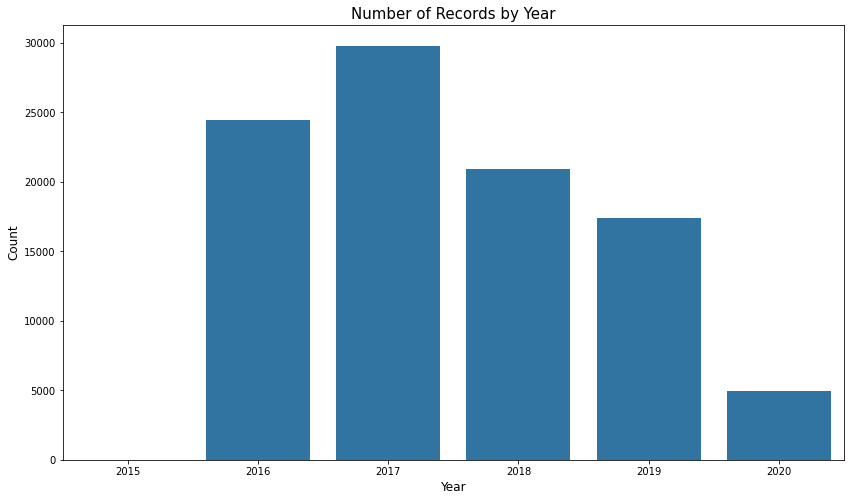

In [20]:
# Get counts for each year
datetime_freq = pd.DataFrame(train_metadata["year"].value_counts())
datetime_freq = datetime_freq.reset_index().rename(columns={"year": "count", "index": "year"}).sort_values("year")

# Plot histogram of year
sns.barplot(data=datetime_freq, x="year", y="count", color="tab:blue")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Records by Year", fontsize=15)
plt.show()

The data span from 2015 to 2020, and there is some difference in counts for each year - particularly for 2015 and 2020.

This may seem unimportant, but given the data source is an app where people can upload photos of their hotel indicates that image data originate from phones. Year-on-year, phone photograph technology has improved dramatically, and the images from 2015 will be noticeably different compared to 2020. It will thus be important to attempt to look into stratifying by year, or figure out how to reconcile this problem.

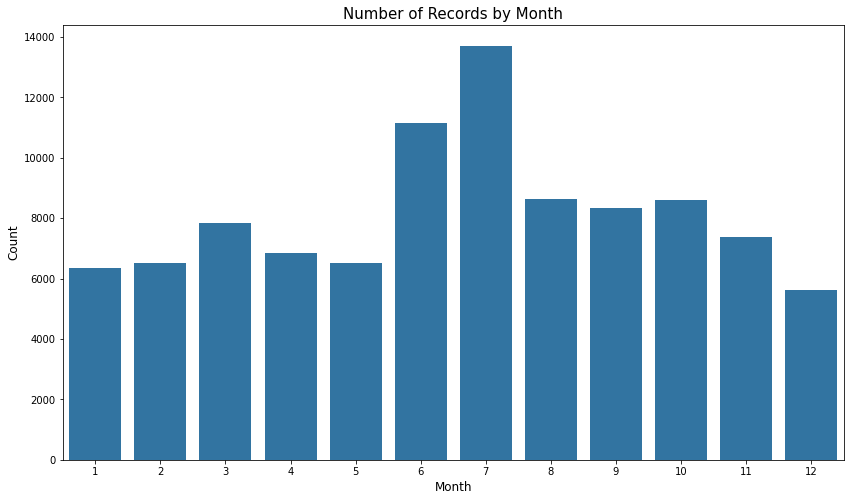

In [21]:
# Get counts for each month
datetime_freq = pd.DataFrame(train_metadata["month"].value_counts())
datetime_freq = datetime_freq.reset_index().rename(columns={"month": "count", "index": "month"})
datetime_freq = datetime_freq.sort_values("month")

# Plot histogram of year
sns.barplot(data=datetime_freq, x="month", y="count", color="tab:blue")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Records by Month", fontsize=15)
plt.show()

While most months are quite equal in counts, it is unexpected that the summer months of June and July (6 & 7) have the highest numbers. This may not neccessarily affect the model, but it is useful knowledge to have as we might be able to add it to the cross validation strategy. If a robust solution to account for this information in the training strategy is found I imagine it would benefit modelling.

The reason why this might make a difference is that there could be some data leakage if we ignore the month. Some seasonal hotels are only open during summer months or vice versa, or at the very least there will be a seasonal factor involved (more images of seaside hotels occur in summer months). There may also be aspects of the image too, such as images are in general higher in brightness during summer months than winter months. Model generalisation will only improve if we can take this into account.

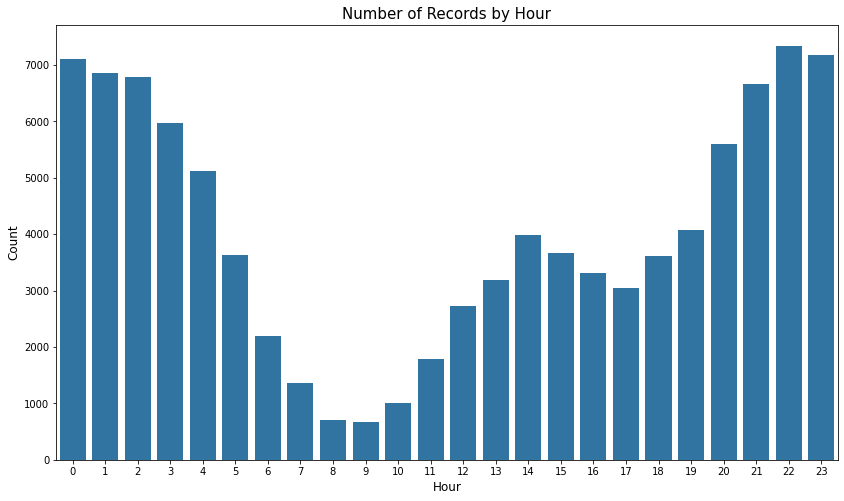

In [22]:
# Get counts for each hour
datetime_freq = pd.DataFrame(train_metadata["hour"].value_counts())
datetime_freq = datetime_freq.reset_index().rename(columns={"hour": "count", "index": "hour"}).sort_values("hour")

# Plot histogram of year
sns.barplot(data=datetime_freq, x="hour", y="count", color="tab:blue")
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Records by Hour", fontsize=15)
plt.show()

Interestingly, the above suggests that most images have been taken during darker hours - which will certainly have an impact on the image. Given our reservations about how accurate the time fragment of the timestamp is though, we will have to confirm this using the actual images to see if this is actually the case. It might be the case that images aren't uploaded as they are taken, or that the timestamp may not be the local time for the user, but rather the time logged at the server location. 

If the data are accurate though, we might want to consider comparing model performance for RGB vs grayscale images. 

In [23]:
# Extract is_weekend from timestamp
def get_is_weekend(timestamp_col):
    """
    Returns boolean for whether timestamp is a weekend.
    """
    timestamp_col_weekday = timestamp_col.dt.weekday
    # Allocate booleans - Weekends are designated 6 & 7
    timestamp_col_weekday = timestamp_col_weekday.apply(lambda x: False if x < 5 else True)
    
    return timestamp_col_weekday

train_metadata["is_weekend"] = get_is_weekend(train_metadata["timestamp"])

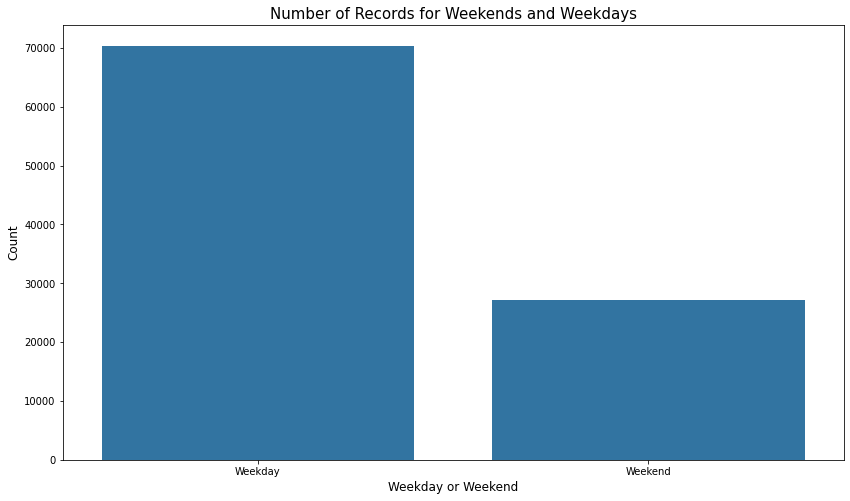

In [24]:
# Get counts for is_weekend
datetime_freq = pd.DataFrame(train_metadata["is_weekend"].value_counts())
datetime_freq = datetime_freq.reset_index().rename(columns={"is_weekend": "count", "index": "is_weekend"})
datetime_freq = datetime_freq.sort_values("is_weekend")

datetime_freq.loc[datetime_freq.is_weekend == True, "is_weekend"] = "Weekend"
datetime_freq.loc[datetime_freq.is_weekend == False, "is_weekend"] = "Weekday"

# Plot histogram of year
sns.barplot(data=datetime_freq, x="is_weekend", y="count", color="tab:blue")
plt.xlabel("Weekday or Weekend", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Records for Weekends and Weekdays", fontsize=15)
plt.show()

Given that there are 5 weekdays and only 2 weekends, it's expected that there are more records for weekdays. But this is important to look into, for the same reasons as looking into month. Hotels, such as airport hotels, may have higher frequency of weekday images. Again, however, we cannot profess to know based on the competition information whether users are uploading images as soon as they are taken - they could be taken and uploaded as a batch following the visit. This feature of the data could be useful, depending on data quality, but won't be prioritised over the less granular features created from timestamp - such as year and month.

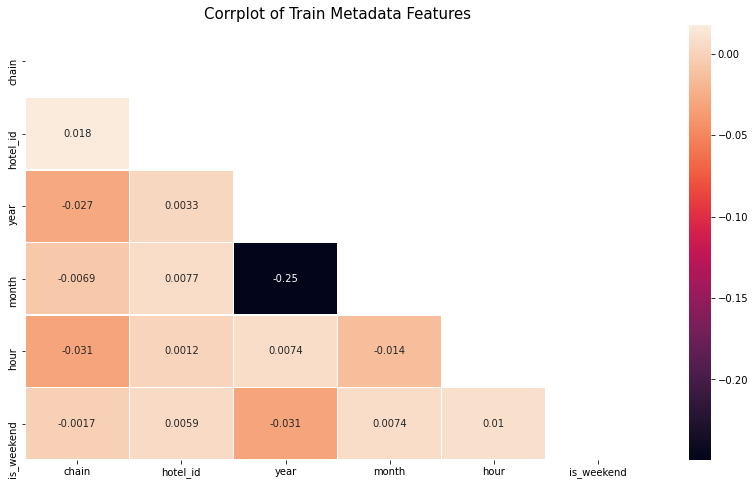

In [25]:
# Get correlation coefficients for all features
corr = train_metadata.drop(["image", "timestamp"], axis=1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=corr, annot=True, linewidths=0.5, mask=mask)
plt.title("Corrplot of Train Metadata Features", fontsize=15)
plt.show()

In [26]:
del train_metadata_dupes, train_metadata_dupes_idx, train_chain_stats, train_hotel_id_stats, coeff
del pvalue, datetime_freq, corr, mask

The above confirms that there are no correlations that we should be aware of (particularly in terms of how hotel ID and chain ID integers are allocated).

## 4.00 Train Images

TODO: 
 - Colour correction (https://github.com/SIlvaMFPedro/pyimagesearch/tree/master/opencv-color-correction)
 - Anomaly detection (https://github.com/SIlvaMFPedro/pyimagesearch/tree/master/anomaly-detection)
 - Detect low contrast images (https://github.com/SIlvaMFPedro/pyimagesearch/tree/master/detect-low-contrast)

### 4.01 Read in images

In [27]:
def get_image_paths(image_dir_path):
    """Reads images into np.array from directory of image files.

    Parameters
    ----------
    image_dir : list
        Directory of images to read from.

    Returns
    -------
    list
        List of images paths to.

    """
    
    # Get list of all image paths
    image_path_list = []
    
    for chain_id in os.listdir(image_dir_path):
        # Each subdirectory is a chain_id
        chain_id_dir_path = os.path.join(image_dir_path, chain_id)
        # Read images from each chain_id subdirectory
        for image in os.listdir(chain_id_dir_path): 
            # Read image
            image_path = os.path.join(chain_id_dir_path, image)
            # Append to list of images
            image_path_list.append(image_path)    

    return(image_path_list)


def load_image(image_path, rows=ROWS, cols=COLS):
    """
    Read and return resized image.
    """
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (rows, cols))
        return image
    except:
        pass

In [28]:
# Get all full image paths
image_path_list = get_image_paths(train_images_dir_path)

In [29]:
%%time
# Read in images asyncrously
pool = multiprocessing.Pool(processes=cpus)
image_array = np.array(pool.map(load_image, image_path_list))
pool.close()
pool.join()

CPU times: user 1min 8s, sys: 1min 2s, total: 2min 11s
Wall time: 9min 16s


### 4.02 RGB Analysis

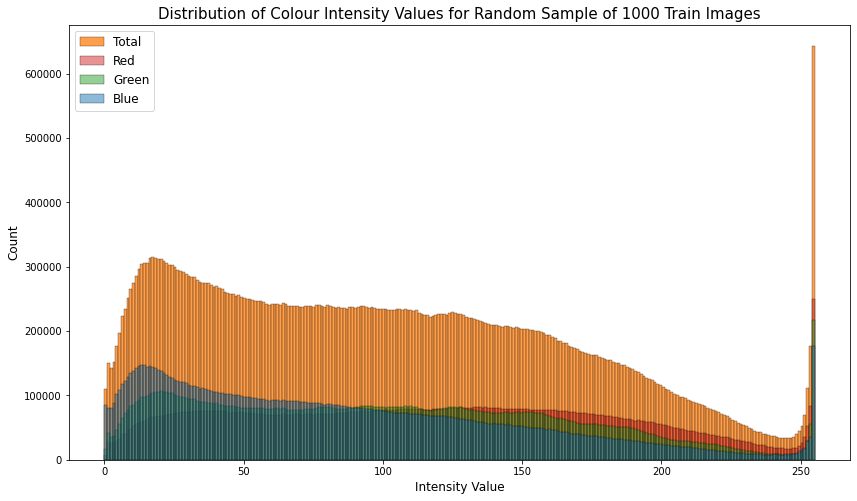

In [30]:
# Plot all colour intensities for all images
#image_sample = np.random.choice(image_array.shape[0], 1000, replace=False)
image_sample = np.random.choice(image_array.shape[0], 100, replace=False)
sns.histplot(image_array[image_sample].ravel(), bins = 256, color="tab:orange", label="Total")
sns.histplot(image_array[image_sample, :, :, 0].ravel(), bins=256, color="tab:red", alpha=0.5, label="Red")
sns.histplot(image_array[image_sample, :, :, 1].ravel(), bins=256, color="tab:green", alpha=0.5, label="Green")
sns.histplot(image_array[image_sample, :, :, 2].ravel(), bins=256, color="tab:blue", alpha=0.5, label="Blue")
plt.legend(fontsize=12)
plt.xlabel("Intensity Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Colour Intensity Values for Random Sample of 1000 Train Images", fontsize=15)
plt.show()

The colour intensities are somewhat evenly distributed (counts of red, green and blue pixel values are quite uniform across all images).

It looks like there is a slight skew for blue values towards lower intensity values, and the opposite for red and green intensity values. It is currently unclear as to whether this indicates a higher or lower level of lighting throughout all images. While the general skew to lower intensity values for all paired with a dramatic spike at the highest end could indicate images that are mostly dark with some lights turned on (hence the large spike), it doesn't confirm that this is definitely the case. 

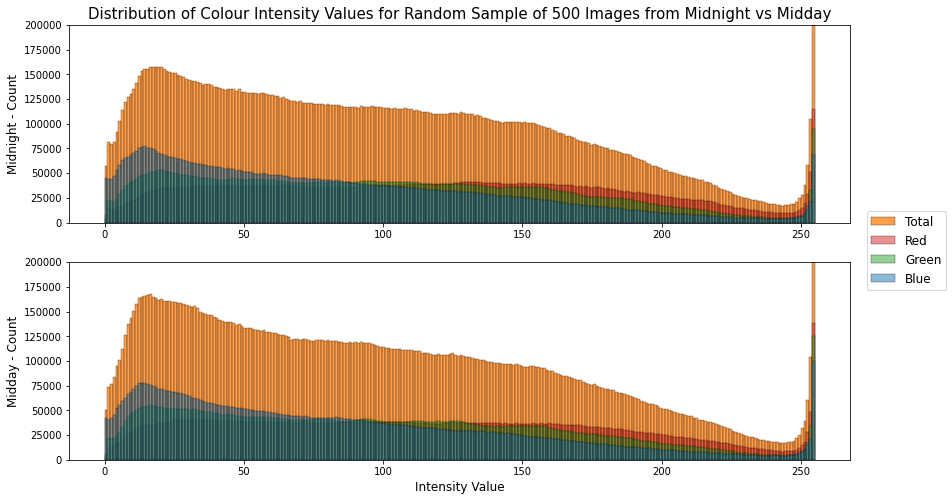

In [31]:
# Plot all colour intensities for images taken in the midnight vs midday hour
del image_array

# Midnight images - subset
image_path_list_df = pd.DataFrame({"image_path": image_path_list})
image_path_list_df["image"] = image_path_list_df["image_path"].apply(lambda x: x.split("/")[5])
image_path_list_df = pd.merge(
    image_path_list_df,
    train_metadata.loc[train_metadata.hour == 0, "image"],
    on="image"
)
image_path_list_midnight = list(image_path_list_df["image_path"])
pool = multiprocessing.Pool(processes=cpus)
image_array_midnight = np.array(pool.map(load_image, image_path_list_midnight))
pool.close()
pool.join()

# Midday images - subset
image_path_list_df = pd.DataFrame({"image_path": image_path_list})
image_path_list_df["image"] = image_path_list_df["image_path"].apply(lambda x: x.split("/")[5])
image_path_list_df = pd.merge(
    image_path_list_df,
    train_metadata.loc[train_metadata.hour == 12, "image"],
    on="image"
)
image_path_list_midday = list(image_path_list_df["image_path"])
pool = multiprocessing.Pool(processes=cpus)
image_array_midday = np.array(pool.map(load_image, image_path_list_midday))
pool.close()
pool.join()

fig, axs = plt.subplots(nrows=2)

# Midnight images - plot color intensities
image_sample = np.random.choice(image_array_midnight.shape[0], 500, replace=False)
sns.histplot(
    image_array_midnight[image_sample].ravel(), 
    bins = 256, color="tab:orange", label="Total", ax=axs[0]
)
sns.histplot(
    image_array_midnight[image_sample, :, :, 0].ravel(), 
    bins=256, color="tab:red", alpha=0.5, label="Red", ax=axs[0]
)
sns.histplot(
    image_array_midnight[image_sample, :, :, 1].ravel(), 
    bins=256, color="tab:green", alpha=0.5, label="Green", ax=axs[0]
)
sns.histplot(
    image_array_midnight[image_sample, :, :, 2].ravel(), 
    bins=256, color="tab:blue", alpha=0.5, label="Blue", ax=axs[0]
)

# Midday images - plot colour intensities
image_sample = np.random.choice(image_array_midday.shape[0], 500, replace=False)
sns.histplot(
    image_array_midday[image_sample].ravel(), 
    bins = 256, color="tab:orange", ax=axs[1]
)
sns.histplot(
    image_array_midday[image_sample, :, :, 0].ravel(), 
    bins=256, color="tab:red", alpha=0.5, ax=axs[1]
)
sns.histplot(
    image_array_midday[image_sample, :, :, 1].ravel(), 
    bins=256, color="tab:green", alpha=0.5, ax=axs[1]
)
sns.histplot(
    image_array_midday[image_sample, :, :, 2].ravel(), 
    bins=256, color="tab:blue", alpha=0.5, ax=axs[1]
)

del image_path_list_df, image_path_list_midnight, image_path_list_midday

fig.legend(fontsize=12, loc="right")
axs[0].set_title(
    "Distribution of Colour Intensity Values for Random Sample of 500 Images from Midnight vs Midday", 
    fontsize=15
)
axs[0].set_ylabel("Midnight - Count", fontsize=12)
axs[0].set_ylim([0, 200000])
axs[1].set_ylabel("Midday - Count", fontsize=12)
axs[1].set_xlabel("Intensity Value", fontsize=12)
axs[1].set_ylim([0, 200000])
plt.show()

Examining the RGB intensity value distributions for midnight and midday doesn't demonstrate a huge difference. The only insight we can see is the spike at the end of the intensity value distribution is more noticeable for midday images. Let's examine the same plot but for December vs July to see if there are any similar observations. 

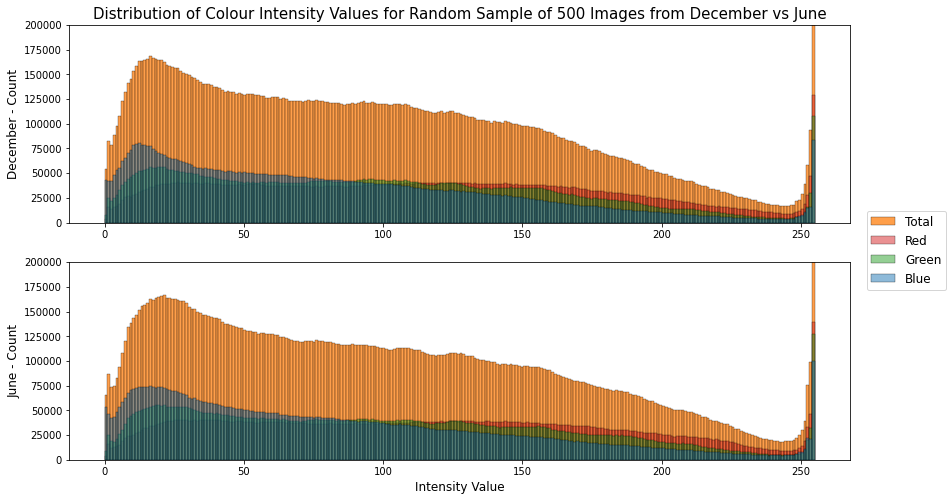

In [35]:
# Plot all colour intensities for images taken in the Dec vs June

# December images - subset
image_path_list_df = pd.DataFrame({"image_path": image_path_list})
image_path_list_df["image"] = image_path_list_df["image_path"].apply(lambda x: x.split("/")[5])
image_path_list_df = pd.merge(
    image_path_list_df,
    train_metadata.loc[train_metadata.month == 12, "image"],
    on="image"
)
image_path_list_dec = list(image_path_list_df["image_path"])
pool = multiprocessing.Pool(processes=cpus)
image_array_dec = np.array(pool.map(load_image, image_path_list_dec))
pool.close()
pool.join()

# June images - subset
image_path_list_df = pd.DataFrame({"image_path": image_path_list})
image_path_list_df["image"] = image_path_list_df["image_path"].apply(lambda x: x.split("/")[5])
image_path_list_df = pd.merge(
    image_path_list_df,
    train_metadata.loc[train_metadata.month == 6, "image"],
    on="image"
)
image_path_list_jun = list(image_path_list_df["image_path"])
pool = multiprocessing.Pool(processes=cpus)
image_array_jun = np.array(pool.map(load_image, image_path_list_jun))
pool.close()
pool.join()

fig, axs = plt.subplots(nrows=2)

# December images - plot colour intensities
image_sample = np.random.choice(image_array_dec.shape[0], 500, replace=False)
sns.histplot(
    image_array_dec[image_sample].ravel(), 
    bins = 256, color="tab:orange", label="Total", ax=axs[0]
)
sns.histplot(
    image_array_dec[image_sample, :, :, 0].ravel(), 
    bins=256, color="tab:red", alpha=0.5, label="Red", ax=axs[0]
)
sns.histplot(
    image_array_dec[image_sample, :, :, 1].ravel(), 
    bins=256, color="tab:green", alpha=0.5, label="Green", ax=axs[0]
)
sns.histplot(
    image_array_dec[image_sample, :, :, 2].ravel(), 
    bins=256, color="tab:blue", alpha=0.5, label="Blue", ax=axs[0]
)

# June images - plot colour intensities
image_sample = np.random.choice(image_array_jun.shape[0], 500, replace=False)
sns.histplot(
    image_array_jun[image_sample].ravel(), 
    bins = 256, color="tab:orange", ax=axs[1]
)
sns.histplot(
    image_array_jun[image_sample, :, :, 0].ravel(), 
    bins=256, color="tab:red", alpha=0.5, ax=axs[1]
)
sns.histplot(
    image_array_jun[image_sample, :, :, 1].ravel(), 
    bins=256, color="tab:green", alpha=0.5, ax=axs[1]
)
sns.histplot(
    image_array_jun[image_sample, :, :, 2].ravel(), 
    bins=256, color="tab:blue", alpha=0.5, ax=axs[1]
)

del image_path_list_df, image_path_list_dec, image_path_list_jun

fig.legend(fontsize=12, loc="right")
axs[0].set_title(
    "Distribution of Colour Intensity Values for Random Sample of 500 Images from December vs June", 
    fontsize=15
)
axs[0].set_ylabel("December - Count", fontsize=12)
axs[0].set_ylim([0, 200000])
axs[1].set_ylabel("June - Count", fontsize=12)
axs[1].set_xlabel("Intensity Value", fontsize=12)
axs[1].set_ylim([0, 200000])
plt.show()

Again, as with midnight vs midday, there doesn't appear to be a large difference in distributions of RGB intensity values for December and July. 

Let's observe the mean intensity values across channels for both Midnight vs Midday and December vs July. 

In [33]:
# Display mean intensity values for all channels - midnight vs midday
pd.DataFrame(
    {
        "Channel": ["Total", "Red", "Green", "Blue"],
        "Midnight - Mean Intensity Value": [
            np.mean(image_array_midnight[:, :, :, :].ravel()),
            np.mean(image_array_midnight[:, :, :, 0].ravel()),
            np.mean(image_array_midnight[:, :, :, 1].ravel()),
            np.mean(image_array_midnight[:, :, :, 2].ravel())
        ],
        "Midday - Mean Intensity Value": [
            np.mean(image_array_midday[:, :, :, :].ravel()),
            np.mean(image_array_midday[:, :, :, 0].ravel()),
            np.mean(image_array_midday[:, :, :, 1].ravel()),
            np.mean(image_array_midday[:, :, :, 2].ravel())
        ]
    }
)

,Channel,Midnight - Mean Intensity Value,Midday - Mean Intensity Value
0,Total,100.032242,100.961133
1,Red,117.317328,117.083087
2,Green,100.375305,101.340477
3,Blue,82.404091,84.459835


In [34]:
# Display mean intensity values for all channels - midnight vs midday
pd.DataFrame(
    {
        "Channel": ["Total", "Red", "Green", "Blue"],
        "Midnight - Mean Intensity Value": [
            np.mean(image_array_dec[:, :, :, :].ravel()),
            np.mean(image_array_dec[:, :, :, 0].ravel()),
            np.mean(image_array_dec[:, :, :, 1].ravel()),
            np.mean(image_array_dec[:, :, :, 2].ravel())
        ],
        "Midday - Mean Intensity Value": [
            np.mean(image_array_jun[:, :, :, :].ravel()),
            np.mean(image_array_jun[:, :, :, 0].ravel()),
            np.mean(image_array_jun[:, :, :, 1].ravel()),
            np.mean(image_array_jun[:, :, :, 2].ravel())
        ]
    }
)

,Channel,Midnight - Mean Intensity Value,Midday - Mean Intensity Value
0,Total,99.786898,100.827267
1,Red,117.081309,116.244969
2,Green,100.017623,101.260812
3,Blue,82.261760,84.976021


The above is a bit more telling - there are effect sizes that we'd expect for intensity values across channels. For both midnight and December images, the mean intensity value for the red channel is slightly higher, and for the blue channel is lower. Intuitively, it's hard to tell what the cause of this would be (without further analysis), but at the very least it indicates that there is some difference among image colours depending on when the image is taken after all. What this tells us is to definitely consider taking into account the timestamp as part of our stratfied cross-validation strategy. It also suggests that we can look into colour correction to try and temporally normalise the intensity values. 

### 4.03 Colour Correction
Given that we've confirmed there are definitely some (albeit slight) differences in lighting conditions based on when the image was taken (month and time, let alone other across other features) - although to what extent is hard to tell - we need to take this into account as part of our training process. Imagining it from this perspective: conducting a test with the same lighting conditions will always outperform a test with different lighting conditions, just because of the removal of confounding variables, i.e. illumination. Normally techniques to help this are taken in the image processing and modelling stage (using augmentation methods like Gaussian Blur), but these are quite computationally inefficient, and the level of improvement to gain from these methods are hard to predict. Following a data centric approach is often the better approach.

### Image Duplicates

In [ ]:
!time python3 ../input/detect_duplicates/extract.py \
--images ../input/hotel-id-2021-fgvc8/train_images \
--output ../input/detect_duplicates/temp_output \
--hashes ../input/detect_duplicates/hashes.pickle

In [ ]:
train_hashes = pd.read_pickle(r'../input/detect_duplicates/hashes.pickle')
train_hashes = pd.DataFrame({"hash": train_hashes.keys(), "image_path": train_hashes.values()})
print(f"Number of image duplicates: {len(train_metadata) - len(train_hashes[['hash']].drop_duplicates())}")